# Domain decomposition example using shallow water gravity wave

This example is to demonstrate how to decompose domain and run computation
on Dask's clusters using domain split API. This notebook is based on
1_gravity_wave notebook, and it is recomended to familiarize with it first.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import time
from multimodemodel import StaggeredGrid, Variable
from dask.distributed import LocalCluster, Client

In [7]:
def plot(input: DomainState):
    plt.pcolormesh(input.eta.grid.x, input.eta.grid.y, input.eta.safe_data, shading='auto', vmin=-2, vmax=2)
    plt.axis('equal')
    plt.colorbar()
    plt.show()

# Prepare grid

The first step is to prepare grid and set the initial state. 
It is perfomed in the same way as in any other case.

In [34]:
nx, ny = 200, 200
dx, dy = 1., 1.

x = np.arange(0., dx * nx, dx)
y = np.arange(0., dy * ny, dy)

c_grid = StaggeredGrid.cartesian_c_grid(x, y)

u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
eta = np.exp(-((c_grid.eta.x - nx // 2) ** 2 + (c_grid.eta.y - ny // 2) ** 2) / 10. ** 2)

# Create DomainState

From API_implementation import DomainState, which is child of State class,
but also has additional functionalities for domain decomposition

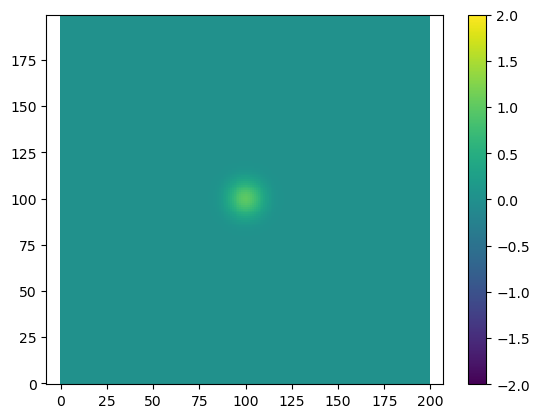

In [35]:
from multimodemodel.API_implementation import DomainState

initial_state = DomainState(
    u=Variable(u, c_grid.u),
    v=Variable(v, c_grid.v),
    eta=Variable(eta, c_grid.eta)
)

plot(initial_state)

Create Dask Client based on cluster of your choice. 
There should be just one one thread per worker.

In [14]:
cluster = LocalCluster(n_workers=16, threads_per_worker=1)

client = Client(cluster)

In [15]:
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37023,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 1 minute ago,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:39895,Total threads: 1
Dashboard: http://127.0.0.1:42327/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:42223,


# Perform computation

Use magic function from API to perform computation. Import classes for solving given problem.

In [40]:
from multimodemodel.API_implementation import Tail, ShallowWater
from multimodemodel.domain_split_API import magic

start = time.time()

# Returns list of Dask's Futres on each subdomain
tmp = magic(initial_state, 20, 10, (1,), ShallowWater(), Tail(), client)
f = client.submit(DomainState.merge, tmp, 1) # Merge all subdomains into one
out = f.result() # Get results

end = time.time()
print("Computation time: {}".format(end - start))

Computation time: 1.996830701828003


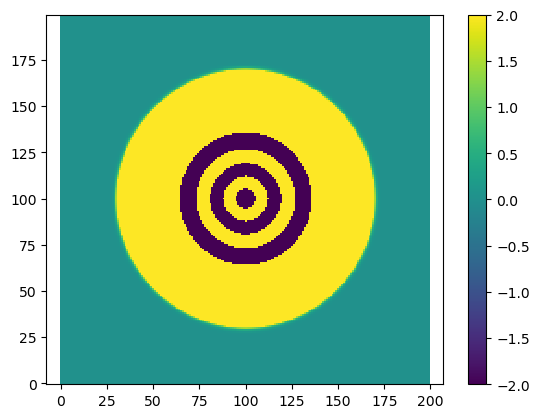

In [41]:
plot(out)